In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sbaghbidi/human-faces-object-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/human-faces-object-detection


# FasterRCNN

In [19]:
import os
import pandas as pd
import numpy as np
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models import VGG16_Weights

In [22]:
class Config:
    DATA_DIR = "/kaggle/input/human-faces-object-detection"
    IMAGES_DIR = os.path.join(DATA_DIR, "images")
    CSV_PATH = os.path.join(DATA_DIR, "faces.csv")
    
    NUM_CLASSES = 2
    BATCH_SIZE = 4
    NUM_EPOCHS = 10
    LEARNING_RATE = 0.001
    MOMENTUM = 0.9
    WEIGHT_DECAY = 0.0005
    
    IMAGE_SIZE = (800, 800)
    DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

config = Config()

In [4]:
class FacesDataset(torch.utils.data.Dataset):
    def __init__(self, data_frame, images_dir, transforms=None, resize_size=(800, 800)):
        self.data = data_frame.reset_index(drop=True)
        self.images_dir = images_dir
        self.transforms = transforms
        self.image_names = self.data['image_name'].unique()
        self.resize_size = resize_size

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        img_path = os.path.join(self.images_dir, image_name)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img) 
        orig_h, orig_w = img.shape[:2] 

        records = self.data[self.data['image_name'] == image_name]
        boxes = records[['x0', 'y0', 'x1', 'y1']].values.astype('float32')

        if len(boxes) == 0:
            boxes = np.zeros((0, 4), dtype='float32')

        valid_boxes = []
        for box in boxes:
            x0, y0, x1, y1 = box
            if x1 > x0 and y1 > y0 and x0 >= 0 and y0 >= 0:
                valid_boxes.append(box)
        
        bboxes_list = valid_boxes
        labels_list = [1] * len(bboxes_list)

        if self.transforms:
            transformed = self.transforms(
                image=img, 
                bboxes=bboxes_list,
                labels=labels_list 
            )
            img = transformed['image']
            bboxes_list = transformed['bboxes']
            labels_list = transformed['labels']

        boxes_tensor = torch.as_tensor(bboxes_list, dtype=torch.float32) if bboxes_list else torch.zeros((0, 4), dtype=torch.float32)
        labels_tensor = torch.as_tensor(labels_list, dtype=torch.int64) if labels_list else torch.ones((0,), dtype=torch.int64)

        target = {
            'boxes': boxes_tensor,
            'labels': labels_tensor,
            'image_id': torch.tensor([idx]),
            'area': (boxes_tensor[:, 3] - boxes_tensor[:, 1]) * (boxes_tensor[:, 2] - boxes_tensor[:, 0]) if len(boxes_tensor) > 0 else torch.tensor([0.0]),
            'iscrowd': torch.zeros((len(boxes_tensor),), dtype=torch.int64),
            'orig_size': torch.tensor([orig_h, orig_w], dtype=torch.float32)
        }

        return img, target

    def collate_fn(self, batch):
        images = [b[0] for b in batch]
        targets = [b[1] for b in batch]
        return images, targets


def get_transform(resize_size=(800, 800)):
    return A.Compose([
        A.Resize(height=resize_size[1], width=resize_size[0]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [5]:
from torch.utils.data import DataLoader, random_split

df = pd.read_csv(config.CSV_PATH) 
dataset = FacesDataset(data_frame=df, images_dir=config.IMAGES_DIR, transforms=get_transform())

total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=4,      
    shuffle=True,
    collate_fn=dataset.collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=dataset.collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=dataset.collate_fn
)

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 1542
Validation dataset size: 440
Test dataset size: 222


Boxes quantity: 2394

Quantiles (25%, 50%, 75%):
Width: [128.81356812 171.00000763 240.61537933]
Height: [149.64029694 198.66665649 280.        ]
Size quantiles: [138.83695683 184.31494724 259.56175799]
Mean Aspect ratio: 0.864


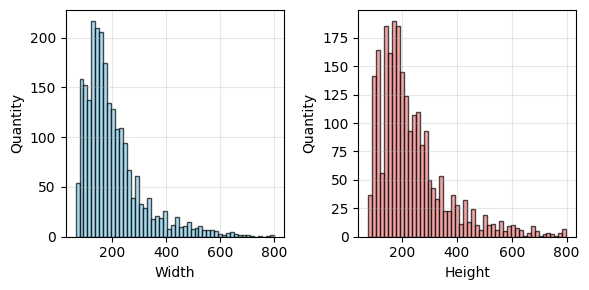

In [6]:
def analyze_bbox_distribution(dataset):
    widths = []
    heights = []
    
    for i in range(len(dataset)):
        _, target = dataset[i]
        boxes = target['boxes'].numpy()
        
        for box in boxes:
            x0, y0, x1, y1 = box
            width = x1 - x0
            height = y1 - y0
            
            widths.append(width)
            heights.append(height)

    
    widths = np.array(widths)
    heights = np.array(heights)
    
    quantiles = {
        'width': np.percentile(widths, [25, 50, 75]),
        'height': np.percentile(heights, [25, 50, 75]),
    }
    
    print(f"Boxes quantity: {len(widths)}")
    print("\nQuantiles (25%, 50%, 75%):")
    print(f"Width: {quantiles['width']}")
    print(f"Height: {quantiles['height']}")

    print(f"Size quantiles: {np.sqrt(quantiles['width'] * quantiles['height'])}")
    print(f"Mean Aspect ratio: {np.mean(widths / heights):.3f}")

    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    
    axes[0].hist(widths, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0].set_xlabel('Width')
    axes[0].set_ylabel('Quantity')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].hist(heights, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[1].set_xlabel('Height')
    axes[1].set_ylabel('Quantity')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    return quantiles

quantiles = analyze_bbox_distribution(train_dataset)

In [7]:
def show_image_with_boxes(image, target, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]):
    img = image.permute(1,2,0).numpy()
    img = (img * torch.tensor(std).numpy() + torch.tensor(mean).numpy()).clip(0,1)
    
    plt.imshow(img)
    plt.axis('off')
    
    boxes = target['boxes']
    for box in boxes:
        x0, y0, x1, y1 = box
        rect = plt.Rectangle(
            (x0, y0), x1-x0, y1-y0,
            fill=False, color='red', linewidth=2
        )
        plt.gca().add_patch(rect)
    
    plt.show()

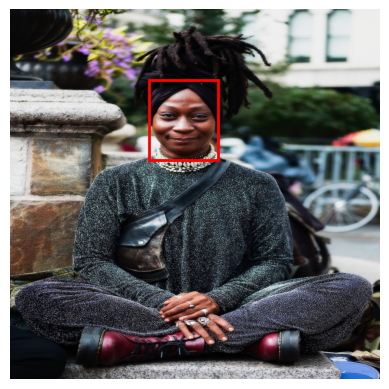

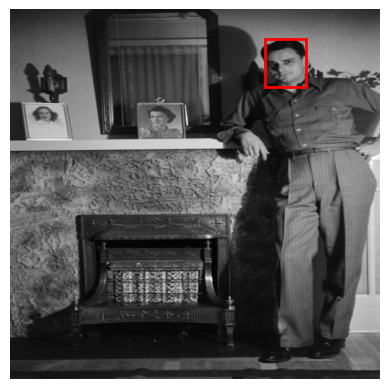

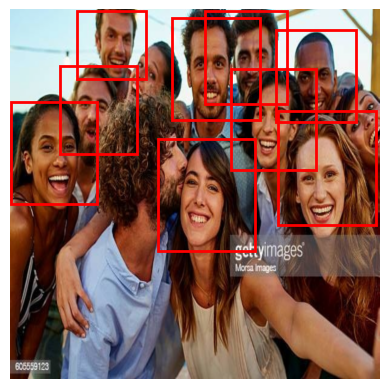

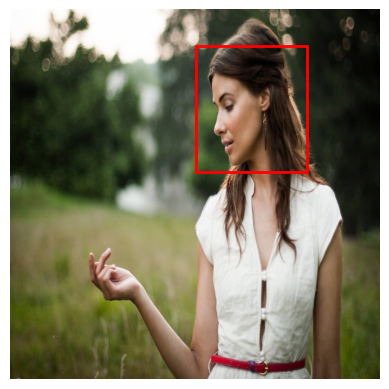

In [10]:
images, targets = next(iter(train_loader))

for img, tgt in zip(images, targets):
    show_image_with_boxes(img, tgt)

In [25]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

def create_model(num_classes):
    backbone = torchvision.models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features
    backbone.out_channels = 512
    
    anchor_generator = AnchorGenerator(
        sizes=((65, 140, 185, 260, 450),),
        aspect_ratios=((0.86),)
    )

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )
    
    model = FasterRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )
    
    return model

In [7]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    total_loss = 0
    
    for i, (images, targets) in enumerate(data_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
    return total_loss / len(data_loader)

In [8]:
def validate_model(model, data_loader, device):
    model.train() 
    val_loss = 0
    
    with torch.no_grad(): 
        for images, targets in data_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()
    
    return val_loss / len(data_loader)

In [9]:
def validate_with_metrics(model, data_loader, device, iou_threshold=0.5, cls_threshold=0.5):
    model.eval()
    total_iou = 0
    total_samples = 0
    total_tp = total_fp = total_fn = 0
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = [image.to(device) for image in images]
            predictions = model(images)
            
            for pred, target in zip(predictions, targets):
                pred_boxes = pred['boxes'].cpu()
                pred_scores = pred['scores'].cpu()
                target_boxes = target['boxes'].cpu()
                
                keep = pred_scores > cls_threshold
                pred_boxes = pred_boxes[keep]
                
                if len(pred_boxes) > 0 and len(target_boxes) > 0:
                    iou_matrix = torchvision.ops.box_iou(pred_boxes, target_boxes)
                    max_iou_per_gt = iou_matrix.max(dim=0)[0]
                    total_iou += max_iou_per_gt.mean().item()
                    total_samples += 1
                
                if len(pred_boxes) == 0 and len(target_boxes) == 0:
                    continue
                elif len(pred_boxes) == 0:
                    total_fn += len(target_boxes)
                    continue
                elif len(target_boxes) == 0:
                    total_fp += len(pred_boxes)
                    continue
                
                iou_matrix_f1 = torchvision.ops.box_iou(pred_boxes, target_boxes)
                max_iou_per_gt_f1, _ = iou_matrix_f1.max(dim=0)
                
                tp = (max_iou_per_gt_f1 >= iou_threshold).sum().item()
                fp = len(pred_boxes) - tp
                fn = len(target_boxes) - tp
                
                total_tp += tp
                total_fp += fp
                total_fn += fn
    
    avg_iou = total_iou / total_samples if total_samples > 0 else 0
    precision = total_tp / (total_tp + total_fp + 1e-6)
    recall = total_tp / (total_tp + total_fn + 1e-6)
    f1_score = 2 * precision * recall / (precision + recall + 1e-6)
    
    return {
        'iou': avg_iou,
        'f1': f1_score,
        'precision': precision,
        'recall': recall,
        'tp': total_tp,
        'fp': total_fp,
        'fn': total_fn,
    }

In [10]:
from torchmetrics.detection import MeanAveragePrecision

def evaluate_model(model, data_loader, device, iou_threshold=0.5, cls_threshold=0.5):
    model.eval()
    
    metrics = validate_with_metrics(model, data_loader, device, iou_threshold, cls_threshold)
    
    map_metric_50 = MeanAveragePrecision(iou_thresholds=[0.5])
    map_metric_95 = MeanAveragePrecision(iou_thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = [image.to(device) for image in images]
            predictions = model(images)
            
            preds_formatted = []
            targets_formatted = []
            
            for pred, target in zip(predictions, targets):
                pred_formatted = {
                    'boxes': pred['boxes'].cpu(),
                    'scores': pred['scores'].cpu(),
                    'labels': pred['labels'].cpu()
                }
                target_formatted = {
                    'boxes': target['boxes'].cpu(),
                    'labels': target['labels'].cpu()
                }
                preds_formatted.append(pred_formatted)
                targets_formatted.append(target_formatted)
            
            map_metric_50.update(preds_formatted, targets_formatted)
            map_metric_95.update(preds_formatted, targets_formatted)
    
    results_50 = map_metric_50.compute()
    results_95 = map_metric_95.compute()
        
    return {
        'mAP_50': results_50['map'].item(),
        'mAP_95': results_95['map'].item(),
        'val_metrics': metrics
    }

In [11]:
def visualize_predictions(model, dataset, device, num_images=3):
    model.eval()
    indices = np.random.choice(len(dataset), num_images)
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    if num_images == 1:
        axes = [axes]
    
    for idx, ax in zip(indices, axes):
        image, target = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            prediction = model(image_tensor)[0]
        
        image_np = image.permute(1, 2, 0).cpu().numpy()
        image_np = (image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
        image_np = np.clip(image_np, 0, 255).astype(np.uint8)
        
        ax.imshow(image_np)
        
        for box in target['boxes']:
            rect = patches.Rectangle(
                (box[0], box[1]), box[2]-box[0], box[3]-box[1],
                linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth'
            )
            ax.add_patch(rect)
        
        for box, score in zip(prediction['boxes'], prediction['scores']):
            if score > 0.5:
                box = box.cpu().numpy()
                rect = patches.Rectangle(
                    (box[0], box[1]), box[2]-box[0], box[3]-box[1],
                    linewidth=2, edgecolor='r', facecolor='none', label='Prediction'
                )
                ax.add_patch(rect)
                ax.text(box[0], box[1], f'{score:.2f}', color='white', 
                       bbox=dict(boxstyle="round,pad=0.3", fc='red', alpha=0.7))
        
        ax.set_title(f'Image {idx}')
        ax.axis('off')
    
    handles, labels = axes[0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    if len(by_label) > 0:
        fig.legend(by_label.values(), by_label.keys(), loc='upper center')
    
    plt.tight_layout()
    plt.show()

In [26]:
def run_model(config):
    model = create_model(config.NUM_CLASSES)
    model.to(config.DEVICE)
    
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(
        params, 
        lr=config.LEARNING_RATE,
        momentum=config.MOMENTUM,
        weight_decay=config.WEIGHT_DECAY
    )
    
    print("Training...")
    train_losses = []
    val_losses = []
    val_ious = []

    for epoch in range(config.NUM_EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{config.NUM_EPOCHS} ---")
        
        train_loss = train_one_epoch(model, optimizer, train_loader, config.DEVICE, epoch+1)
        train_losses.append(train_loss)
        
        val_loss = validate_model(model, val_loader, config.DEVICE)
        val_losses.append(val_loss)
        
        val_metrics = validate_with_metrics(model, val_loader, config.DEVICE)
        val_f1 = val_metrics['f1']

        val_iou = val_metrics['iou']
        val_ious.append(val_iou)
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}, Val F1: {val_f1:.4f}")

    torch.save(model.state_dict(), 'face_detection_model.pth')

    print("\nTest evaluation...")
    test_metrics = evaluate_model(model, test_loader, config.DEVICE)

    print(f"mAP@0.5:       {test_metrics['mAP_50']:.4f}")
    print(f"mAP@0.5:0.95:  {test_metrics['mAP_95']:.4f}")
    print(f"IoU:           {test_metrics['val_metrics']['iou']:.4f}")
    print(f"F1-Score:      {test_metrics['val_metrics']['f1']:.4f}")
    print(f"Precision:     {test_metrics['val_metrics']['precision']:.4f}")
    print(f"Recall:        {test_metrics['val_metrics']['recall']:.4f}")
    print(f"True Positives:  {test_metrics['val_metrics']['tp']}")
    print(f"False Positives: {test_metrics['val_metrics']['fp']}")
    print(f"False Negatives: {test_metrics['val_metrics']['fn']}")
    
    visualize_predictions(model, test_dataset, config.DEVICE)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, config.NUM_EPOCHS + 1), train_losses, label='Train Loss')
    plt.plot(range(1, config.NUM_EPOCHS + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, config.NUM_EPOCHS + 1), val_ious, label='Validation IoU', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.title('Validation IoU')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

    return model

Training...

--- Epoch 1/10 ---
Train Loss: 0.2177, Val Loss: 0.1413, Val IoU: 0.6859, Val F1: 0.7786

--- Epoch 2/10 ---
Train Loss: 0.1231, Val Loss: 0.1158, Val IoU: 0.7608, Val F1: 0.8105

--- Epoch 3/10 ---
Train Loss: 0.1092, Val Loss: 0.1117, Val IoU: 0.7668, Val F1: 0.8339

--- Epoch 4/10 ---
Train Loss: 0.0968, Val Loss: 0.1004, Val IoU: 0.7897, Val F1: 0.8755

--- Epoch 5/10 ---
Train Loss: 0.0898, Val Loss: 0.0969, Val IoU: 0.8007, Val F1: 0.8238

--- Epoch 6/10 ---
Train Loss: 0.0862, Val Loss: 0.0934, Val IoU: 0.8102, Val F1: 0.8921

--- Epoch 7/10 ---
Train Loss: 0.0809, Val Loss: 0.0941, Val IoU: 0.8188, Val F1: 0.8715

--- Epoch 8/10 ---
Train Loss: 0.0766, Val Loss: 0.0902, Val IoU: 0.8235, Val F1: 0.8787

--- Epoch 9/10 ---
Train Loss: 0.0753, Val Loss: 0.0908, Val IoU: 0.8143, Val F1: 0.8617

--- Epoch 10/10 ---
Train Loss: 0.0706, Val Loss: 0.0897, Val IoU: 0.8340, Val F1: 0.8877

Test evaluation...
mAP@0.5:       0.9434
mAP@0.5:0.95:  0.6715
IoU:           0.8483
F

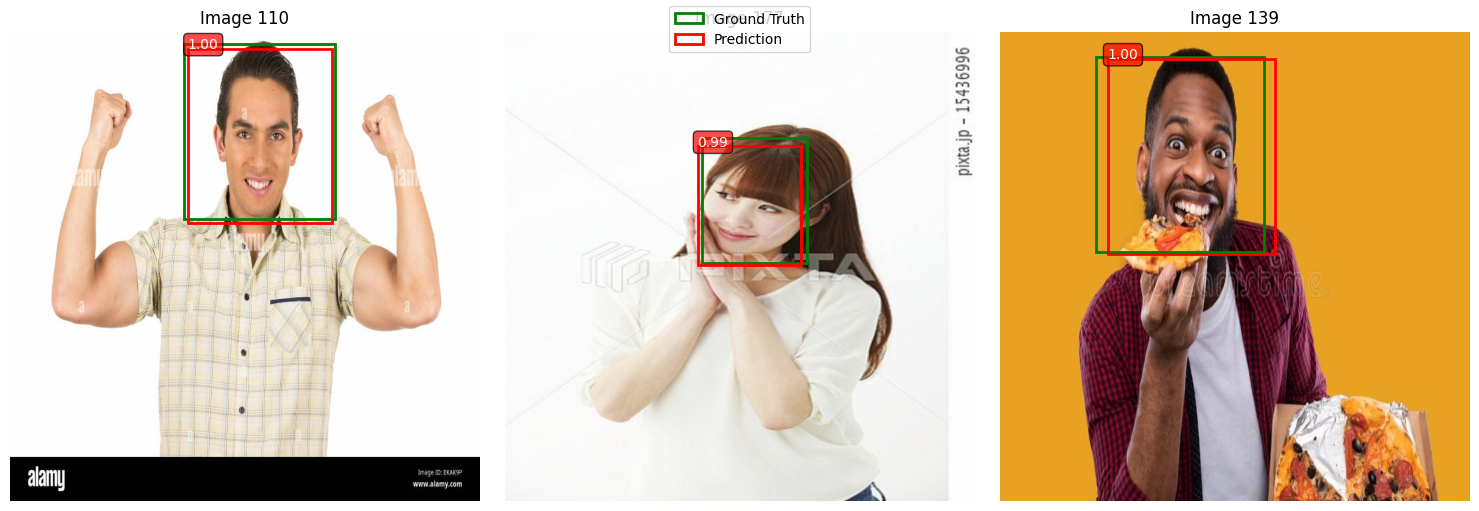

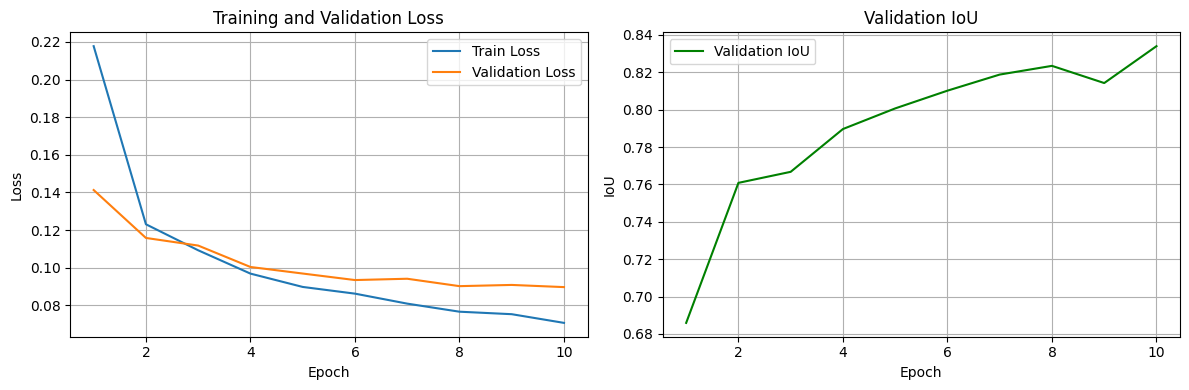

In [27]:
model1 = run_model(config)

# Custom RPN

In [13]:
import torch.nn as nn
import torch.nn.functional as NF
from torchvision.ops import nms, box_iou

In [14]:
class CustomRPN(nn.Module):
    def __init__(self, in_channels, anchor_generator):
        super().__init__()
        self.anchor_generator = anchor_generator

        self.conv = nn.Conv2d(in_channels, 256, 3, 1, 1)
        self.cls_logits = nn.Conv2d(256, anchor_generator.num_anchors_per_location()[0], 1)
        self.bbox_pred = nn.Conv2d(256, anchor_generator.num_anchors_per_location()[0] * 4, 1)

        self.fg_iou_thresh = 0.7
        self.bg_iou_thresh = 0.3
        self.nms_thresh = 0.7
        self.pre_nms_top_n = 2000
        self.post_nms_top_n = 1000

    def forward(self, images, features, targets=None):
        features = next(iter(features.values()))
        
        objectness, pred_bbox_deltas = self._forward_head(features)  
        
        anchors = self.anchor_generator(images, [features])
        
        proposals = self._generate_proposals(pred_bbox_deltas, anchors, images.image_sizes)
        
        boxes = self.filter_proposals(proposals, objectness, images.image_sizes)
        
        losses = {}
        if self.training:
            losses = self.compute_loss(objectness, pred_bbox_deltas, anchors, targets)
        
        return boxes, losses

    def _forward_head(self, features):
        B, C, H, W = features.shape
        
        t = NF.relu(self.conv(features))
        objectness = self.cls_logits(t)
        pred_bbox_deltas = self.bbox_pred(t) 
        
        objectness_flat = []
        pred_bbox_deltas_flat = []
        
        for i in range(B):
            obj_flat = objectness[i].permute(1, 2, 0).reshape(-1) 
            box_flat = pred_bbox_deltas[i].permute(1, 2, 0).reshape(-1, 4)  
            objectness_flat.append(obj_flat)
            pred_bbox_deltas_flat.append(box_flat)
            
        return objectness_flat, pred_bbox_deltas_flat

    def _generate_proposals(self, pred_bbox_deltas, anchors, image_sizes):
        proposals = []
        for i, (deltas, anchors_per_img) in enumerate(zip(pred_bbox_deltas, anchors)):
            proposals_i = self.apply_deltas_to_anchors(deltas, anchors_per_img)
            proposals_i = self.clip_boxes_to_image(proposals_i, image_sizes[i])
            proposals.append(proposals_i)
        return proposals

    def filter_proposals(self, proposals, objectness, image_sizes):
        boxes = []
        
        for i, (proposals_i, obj_i) in enumerate(zip(proposals, objectness)):
            scores = obj_i.sigmoid()
            
            num_topk = min(self.pre_nms_top_n, scores.size(0))
            topk_scores, topk_idx = scores.topk(num_topk)
            topk_boxes = proposals_i[topk_idx]
            
            keep = nms(topk_boxes, topk_scores, self.nms_thresh)
            keep = keep[:self.post_nms_top_n]
            boxes.append(topk_boxes[keep])
            
        return boxes

    def compute_loss(self, objectness, pred_bbox_deltas, anchors, targets):
        labels, matched_gt_boxes = self.assign_targets_to_anchors(anchors, targets)
        
        loss_objectness = torch.tensor(0.0, device=objectness[0].device)
        loss_rpn_box_reg = torch.tensor(0.0, device=pred_bbox_deltas[0].device)
        num_images = len(objectness)
        
        for i in range(num_images):
            valid_mask = labels[i] >= 0
            if valid_mask.sum() > 0:
                loss_objectness += NF.binary_cross_entropy_with_logits(
                    objectness[i][valid_mask],
                    labels[i][valid_mask]
                )
            
            pos_mask = labels[i] == 1
            if pos_mask.sum() > 0:
                target_deltas = self.box_to_deltas(anchors[i][pos_mask], matched_gt_boxes[i][pos_mask])
                loss_rpn_box_reg += NF.smooth_l1_loss(
                    pred_bbox_deltas[i][pos_mask], 
                    target_deltas
                )
        
        loss_objectness = loss_objectness / num_images
        loss_rpn_box_reg = loss_rpn_box_reg / num_images
        
        return {
            "loss_objectness": loss_objectness,
            "loss_rpn_box_reg": loss_rpn_box_reg,
        }

    def assign_targets_to_anchors(self, anchors, targets):
        labels = []
        matched_gt_boxes = []
        
        for anchors_per_image, targets_per_image in zip(anchors, targets):
            gt_boxes = targets_per_image["boxes"]
            
            if gt_boxes.numel() == 0:
                device = anchors_per_image.device
                matched_gt_boxes_per_image = torch.zeros_like(anchors_per_image)
                labels_per_image = torch.zeros(anchors_per_image.shape[0], device=device)
            else:
                iou = box_iou(anchors_per_image, gt_boxes)
                max_iou, gt_idx = iou.max(dim=1)
                
                labels_per_image = torch.full_like(max_iou, -1, dtype=torch.float32)
                labels_per_image[max_iou >= self.fg_iou_thresh] = 1.0
                labels_per_image[max_iou < self.bg_iou_thresh] = 0.0
                
                matched_gt_boxes_per_image = gt_boxes[gt_idx]
            
            labels.append(labels_per_image)
            matched_gt_boxes.append(matched_gt_boxes_per_image)
            
        return labels, matched_gt_boxes

    def box_to_deltas(self, anchors, boxes):
        eps = 1e-6
        anchor_centers = (anchors[:, 2:] + anchors[:, :2]) / 2
        anchor_sizes = anchors[:, 2:] - anchors[:, :2]
    
        box_centers = (boxes[:, 2:] + boxes[:, :2]) / 2
        box_sizes = boxes[:, 2:] - boxes[:, :2]
    
        dxdy = (box_centers - anchor_centers) / (anchor_sizes + eps)
        dwdh = torch.log((box_sizes + eps) / (anchor_sizes + eps))
        return torch.cat([dxdy, dwdh], dim=1)

    def apply_deltas_to_anchors(self, deltas, anchors):
        deltas = torch.clamp(deltas, min=-10, max=10)
        anchor_centers = (anchors[:, 2:] + anchors[:, :2]) / 2
        anchor_sizes = anchors[:, 2:] - anchors[:, :2]
    
        pred_centers = deltas[:, :2] * anchor_sizes + anchor_centers
        pred_sizes = torch.exp(deltas[:, 2:]) * anchor_sizes
    
        boxes = torch.cat([pred_centers - 0.5 * pred_sizes, pred_centers + 0.5 * pred_sizes], dim=1)
        return boxes

    def clip_boxes_to_image(self, boxes, size):
        h, w = size
        boxes[:, 0].clamp_(0, w)  
        boxes[:, 1].clamp_(0, h)  
        boxes[:, 2].clamp_(0, w)  
        boxes[:, 3].clamp_(0, h)  
        return boxes

In [20]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

def create_model(num_classes):
    backbone = torchvision.models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features
    backbone.out_channels = 512

    anchor_generator = AnchorGenerator(
        sizes=((65, 140, 185, 260, 450),),
        aspect_ratios=((0.86),)
    )
    
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )

    rpn = CustomRPN(
        in_channels=backbone.out_channels,
        anchor_generator=anchor_generator,
    )
    
    model = FasterRCNN(
        backbone,
        num_classes=num_classes,
        anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )
    
    model.rpn=rpn
    return model

Training...

--- Epoch 1/10 ---
Train Loss: 0.2741, Val Loss: 0.1658, Val IoU: 0.7174, Val F1: 0.8022

--- Epoch 2/10 ---
Train Loss: 0.1684, Val Loss: 0.1447, Val IoU: 0.7721, Val F1: 0.8540

--- Epoch 3/10 ---
Train Loss: 0.1395, Val Loss: 0.1249, Val IoU: 0.7856, Val F1: 0.8677

--- Epoch 4/10 ---
Train Loss: 0.1239, Val Loss: 0.1274, Val IoU: 0.8017, Val F1: 0.8912

--- Epoch 5/10 ---
Train Loss: 0.1117, Val Loss: 0.1229, Val IoU: 0.8046, Val F1: 0.8774

--- Epoch 6/10 ---
Train Loss: 0.0997, Val Loss: 0.1220, Val IoU: 0.8208, Val F1: 0.9046

--- Epoch 7/10 ---
Train Loss: 0.0951, Val Loss: 0.0987, Val IoU: 0.8190, Val F1: 0.9098

--- Epoch 8/10 ---
Train Loss: 0.0863, Val Loss: 0.1074, Val IoU: 0.8216, Val F1: 0.9062

--- Epoch 9/10 ---
Train Loss: 0.0899, Val Loss: 0.1006, Val IoU: 0.8309, Val F1: 0.8996

--- Epoch 10/10 ---
Train Loss: 0.0789, Val Loss: 0.1001, Val IoU: 0.8122, Val F1: 0.9039

Test evaluation...
mAP@0.5:       0.9355
mAP@0.5:0.95:  0.6365
IoU:           0.8231
F

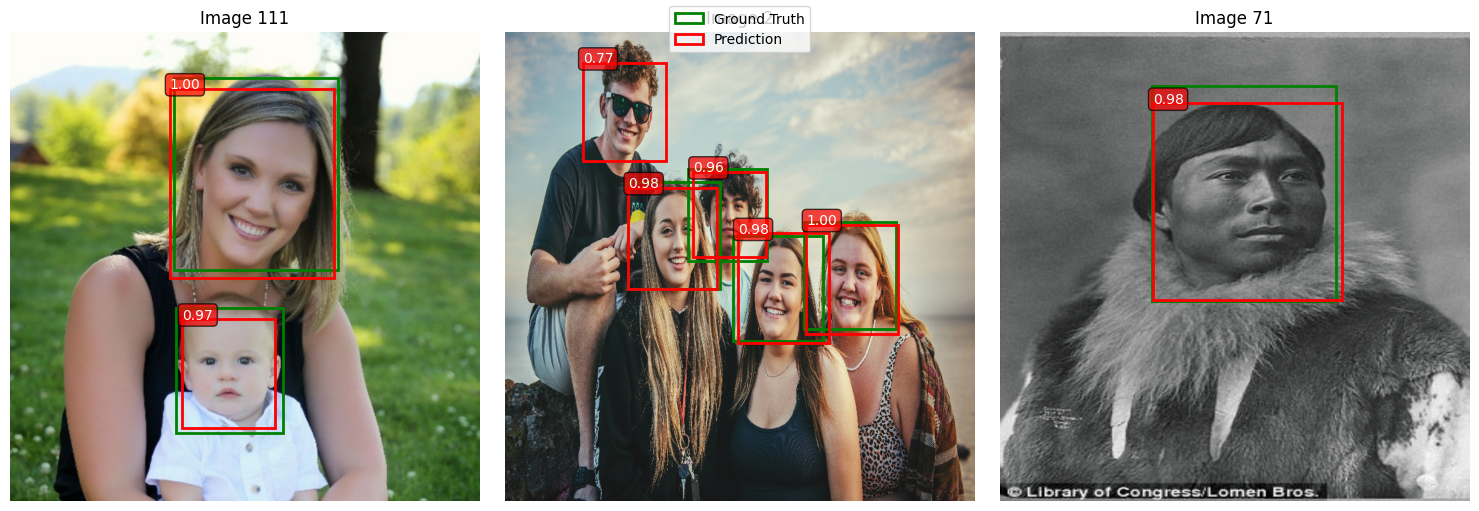

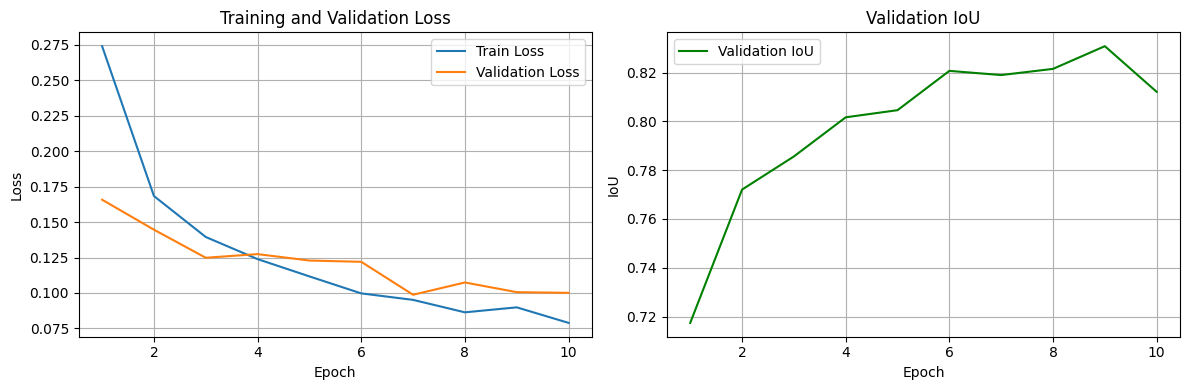

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(in

In [33]:
run_model(config)